Read Text Captions

In [1]:
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [2]:
captions=readTextFile('captions.txt')
captions=captions.split("\n")[:-1]
print(len(captions))

40455


In [3]:
#Dictionary to map each image with caption
descriptions={}
for x in captions:
    first,second=x.split(',')[0],x.split(',')[1]
    img_name=first.split('.')[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
        
    descriptions[img_name].append(second)

In [4]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Data Cleaning

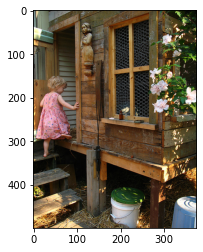

In [5]:
img_path="Images/"
import cv2
import matplotlib.pyplot as plt
img=cv2.imread(img_path+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [6]:
import re

In [7]:
#here we will not remove stopwords and will not stem else the resulting text will not be grammatically incorrect
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence) #remove numbers
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1] #remove single words
    sentence=" ".join(sentence)
    return sentence

In [8]:
clean_text("A child in a pink dress is climbing up a set of stairs in an entry way 65 .")

'child in pink dress is climbing up set of stairs in an entry way'

In [9]:
#Clean all captions
for key,captions in descriptions.items():
    for i in range(len(captions)):
        captions[i]=clean_text(captions[i])

In [10]:
#Write the data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

 Vocabulary

In [11]:
import json

In [12]:
descriptions=None
with open("descriptions.txt",'r') as f:
    descriptions=f.read()
    
descriptions=json.loads(descriptions.replace("'","\""))

In [13]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print(len(vocab))

8257


In [14]:
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print(len(total_words))

357791


In [15]:
#8000 words are selected out of 360000 words 

In [16]:
#filter words from vocab according to certain threshold frequency

In [17]:
import collections
counter=collections.Counter(total_words)
freq_cnt=dict(counter)
#print(freq_cnt)

In [18]:
#sort dictionary
sorted_freq=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

In [19]:
threshold=10
sorted_freq=[x for x in sorted_freq if x[1]>threshold]
total_words=[x[0] for x in sorted_freq]

In [20]:
print(len(total_words))

1800


PREPARE TRAIN AND TEST

In [21]:
train=[]
test=[]
for key in descriptions.keys():
    train.append(key)

In [22]:
n=int(0.8*(len(train)))
test=train[n:]
train=train[:n]

In [23]:
train[:4]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815']

In [24]:
#Prepare description for training data
#we will add start and end token to our training data
train_descriptions={}

for t in train:
    train_descriptions[t]=[]
    for cap in descriptions[t]:
        cap_to_append='start '+cap+' end'
        train_descriptions[t].append(cap_to_append)
            

In [25]:
train_descriptions['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

# TRANSFER LEARNING

IMAGE FEATURE EXTRACTION

In [26]:
from keras.applications import ResNet50
from keras.models import Model
import keras.utils as image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

model=ResNet50(
    #include_top=True,
    weights='imagenet',
    #input_tensor=None,
    input_shape=(224,224,3),
    #pooling=None,
    #classes=1000,
    #**kwargs
)
#model.summary()

In [27]:
model=Model(model.input,model.layers[-2].output)

In [28]:
with open("feature_model.json",'w') as file:
    file.write(model.to_json())
model.save_weights('feature_model.h5')

In [29]:
import numpy as np

In [30]:
#Extract image feature vectors
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0) 
    #Normalisation
    img=preprocess_input(img)
    return img

In [31]:
#img=preprocess_img(img_path+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#print(img.shape)
#plt.show()

In [32]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    #it returns the feature vectors
    return feature_vector

In [33]:
encode_image(img_path+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 3s 3s/step


array([0.06535926, 0.16782555, 0.3251761 , ..., 0.05107139, 0.32821193,
       1.0043361 ], dtype=float32)

In [ ]:
encoding_train={}
for i,img_id in enumerate(train):
    #img=img_path+img_id+".jpg"
    #encoding_train[img_id]=encode_image(img)
    if i%100==0:
        print("encoding in progress %d "%i)

In [35]:
import pickle

In [ ]:
#Store everything to the disk
with open("encoded_train_features.pkl",'wb') as f:
    pickle.dump(encoding_train,f)

In [ ]:
encoding_test={}
for i,img_id in enumerate(test):
    #img=img_path+img_id+".jpg"
    #encoding_test[img_id]=encode_image(img)
    if i%100==0:
        print("encoding in progress %d "%i)

In [ ]:
#Store everything to the disk
with open("encoded_test_features.pkl",'wb') as f:
    pickle.dump(encoding_test,f)

DATA PREPROCESSING FOR CAPTIONS

In [36]:
with open('encoded_train_features.pkl', 'rb') as f:
    encoding_train = pickle.load(f)
with open('encoded_test_features.pkl', 'rb') as f:
    encoding_test = pickle.load(f)

In [37]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [38]:
#2 special words
l=len(idx_to_word)
idx_to_word[l+1]='start'
word_to_idx['start']=l+1

idx_to_word[l+2]='end'
word_to_idx['end']=l+2

In [39]:
#Store everything to the disk
with open("word_to_idx.pkl",'wb') as f:
    pickle.dump(word_to_idx,f)
with open("idx_to_word.pkl",'wb') as f:
    pickle.dump(idx_to_word,f)

In [40]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))

Making Custom Generator

In [41]:
vocab_size=len(total_words)+3 #0 for padding l+1 for start l+2 for end

In [42]:
from keras.utils import np_utils
import keras

In [43]:
def custom_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            photo=encoding_train[key]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                #we create the input and output expected
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    #0 denotes pad word
                    #total classes equals vocab sizes
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=keras.utils.np_utils.to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo) #2048 size feature vec
                    X2.append(xi)   #35 size max len vec
                    y.append(yi)  #vocab size is 1800
                    
                if n==batch_size:
                    #generator remembers the previously occured state
                    #yield for generotor and return for python
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    
                    X1,X2,y=[],[],[]
                    n=0
        
        

WORD EMBEDDINGS

In [44]:
f=open('glove.6B.50d.txt',encoding='utf8')

In [45]:
#get a list of word with there embedded vectors
embedding_index={}
for line in f:
    values=line.split()
    word=values[0]
    embedding_word=np.array(values[1:],dtype='float')
    embedding_index[word]=embedding_word
f.close()

In [46]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix

# MODEL ARCHITECTURE

In [47]:
from keras.layers import *

In [48]:
#image as input
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [49]:
#captions as input
input_captions=Input(shape=(max_len))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [50]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 50)       90150       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [52]:
#Important Thing -Embedding Layer
embedding_matrix=get_embedding_matrix()
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [63]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# TRAINING THE MODEL

In [64]:
epochs=15
batch_size=3
steps=len(train_descriptions)//50

In [65]:
for i in range(epochs):
    generator=custom_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('str(i)'+'.h5')

C:\Users\91893\AppData\Local\Temp\ipykernel_6708\4102678715.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


129/129 [==============================] - 60s 462ms/step - loss: 1.9661


In [66]:
def predict_caption(photo):
    in_text="start"
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax() #word with max probabilty -Greedy Sampling
        word=idx_to_word[ypred]
        in_text+=(" "+word)
        if word =='end':
            break
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 70ms/step


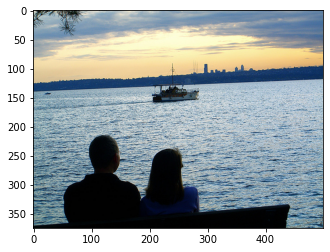

the little boy is being in the water
1/1 [==============================] - 0s 70ms/step


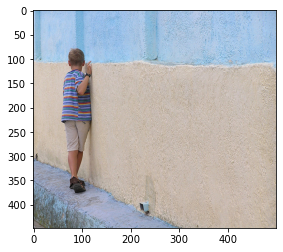

young boy wearing white hair standing tosses to the camera
1/1 [==============================] - 0s 75ms/step


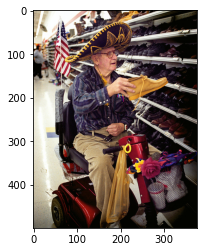

woman wearing red shirt and black jacket is sitting on concrete of front of carnival
1/1 [==============================] - 0s 69ms/step


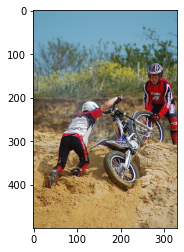

man wearing shirt shirt is standing on the air
1/1 [==============================] - 0s 69ms/step


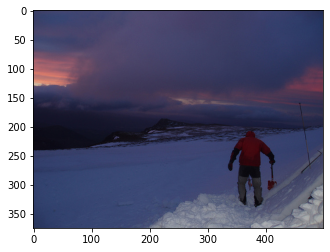

person is snowboarding over snowy over snowy


In [67]:
for i in range(5):
    idx=np.random.randint(0,1000)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo=encoding_test[img_name].reshape((1,2048))
    caption=predict_caption(photo)
    i=plt.imread("Images/"+img_name+".jpg")
    plt.imshow(i)
    plt.show()
    print(caption)
    

In [68]:
with open("model.json",'w') as file:
    file.write(model.to_json())
model.save_weights('model.h5')

In [69]:
from keras.models import model_from_json

In [70]:
with open("model.json",'r') as file:
    model=model_from_json(file.read())
model.load_weights('model.h5')